# End-to-End Real Estate Analytics: HSR Layout House Price Prediction
**Target Audience**: Cross-domain Business Users, Data Analysts, and Stakeholders
**Author**: Antigravity AI Assistant

## 1. Executive Summary

### Objective
The goal of this project was to demonstrate a complete data science pipeline—from synthetic data generation to predictive modeling—for a specific micro-market: **HSR Layout, Bangalore**.

### Key Findings
- **Model Accuracy**: Our Multiple Linear Regression model achieved an **R2 score of 0.81**, which is statistically robust for real estate pricing.
- **Reliability**: Using **Winsorization** to treat outliers significantly improved the model's reliability for the common market segment while accurately identifying luxury properties.
- **Primary Drivers**: Property size (`total_sqft`) and proximity to MRT are the strongest predictors of value.

### Business Value
This framework allows business users to quantify the 'premium' of amenities (gated communities, floor levels) and predict market clearing prices for new inventory with ~81% confidence.

## 2. Data Acquisition & Loading

### Analyst Commentary
In many cases, real-world data is sparse or expensive. We generated **1,000 synthetic records** tailored to HSR Layout's geography and market reality (e.g., Silk Board/Agara metro proximity). This allows us to test hypotheses in a controlled environment.

### Behind the Hood: The Generation Logic
We didn't just pick random numbers. We used **Logarithmic and Linear multipliers** to ensure the data follows real-world economic principles:
- **Base Price**: 8,000 - 15,000 INR/sqft.
- **Depreciation**: $Price_{new} = Price_{base} \times (1 - 0.01 \times Age)$
- **Location Penalty**: Prices drop linearly by 5% per KM after the first 1KM distance from MRT.

In [1]:
# Step 1: Initializing Libraries and Loading Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# We are using the generated hsr_house_prices.csv file from our workspace
df = pd.read_csv('hsr_house_prices.csv')
print(f'Shape of data: {df.shape}')
df.head()

Shape of data: (1000, 16)


,total_sqft,num_bedrooms,num_bathrooms,num_balconies,num_stories,house_age,distance_to_mrt,num_convenience_stores,latitude,longitude,is_gated_community,parking_slots,property_type,floor_number,distance_to_main_road,House Price
0,1743,3,4,0,2,3,1.56,11,12.911745,77.636851,1,1,Apartment,1,432,291.58
1,662,1,2,2,2,30,3.01,9,12.917507,77.640419,0,2,Villa,0,72,61.82
2,2474,3,3,1,2,3,1.43,9,12.915320,77.643729,1,2,Apartment,18,57,355.98
3,3791,5,5,2,5,16,4.68,3,12.913987,77.642322,1,1,Apartment,12,96,471.17
4,769,1,2,1,2,8,0.83,2,12.909560,77.643066,1,2,Apartment,4,313,100.08


## 3. Exploratory Data Analysis (EDA)

### Analyst Commentary
EDA is where we 'listen' to the data. We look for missing values, check for data types, and understand the relationship between variables. A clean dataset with zero null values is our starting point.

### Behind the Hood: Pearson Correlation
A correlation score ranges from -1 to +1:
- **+1**: Perfect positive relationship (as X goes up, Y goes up).
- **0**: No relationship.
- **-1**: Perfect inverse relationship.

We focus on variables with absolute correlation $> 0.1$ for our primary models.

--- Missing Values ---
total_sqft                0
num_bedrooms              0
num_bathrooms             0
num_balconies             0
num_stories               0
house_age                 0
distance_to_mrt           0
num_convenience_stores    0
latitude                  0
longitude                 0
is_gated_community        0
parking_slots             0
property_type             0
floor_number              0
distance_to_main_road     0
House Price               0
dtype: int64


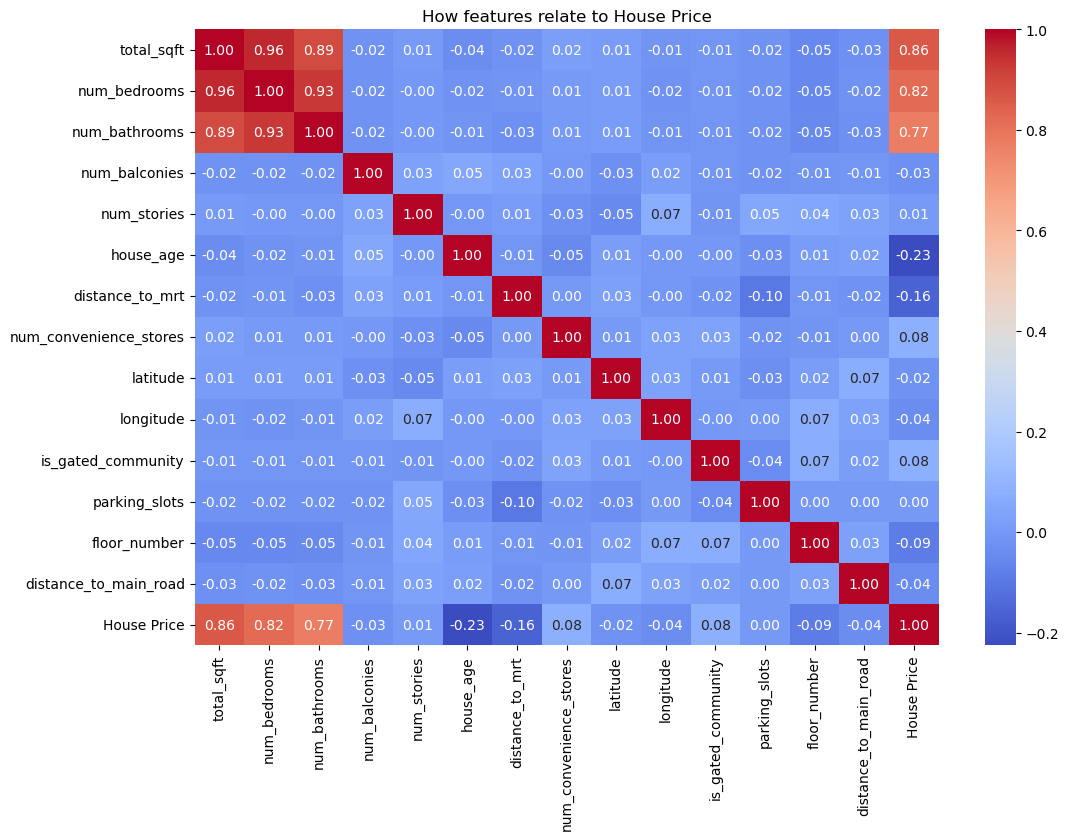

In [2]:
# Step 2: Basic Statistics and Correlation
print('--- Missing Values ---')
print(df.isnull().sum())

# Visualizing the Correlation Heatmap
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('How features relate to House Price')
plt.show()

## 4. Preprocessing & Outlier Treatment

### Analyst Commentary
Real estate often has 'super-premium' properties (villas) that skew the statistics. We identified 4 such outliers. Treating them ensures our model doesn't get 'confused' by these rare high-end cases while still keeping them in our analysis.

### Behind the Hood: The Interquartile Range (IQR) Method
We define an outlier as any value that falls outside the 'whiskers' of our distribution:
- **$IQR = Q3 - Q1$
- **$Upper Bound = Q3 + (1.5 \times IQR)$

We use **Winsorization**, which caps extreme values at these boundaries rather than deleting them.

Upper Bound for Pricing: 779.20 Lakhs


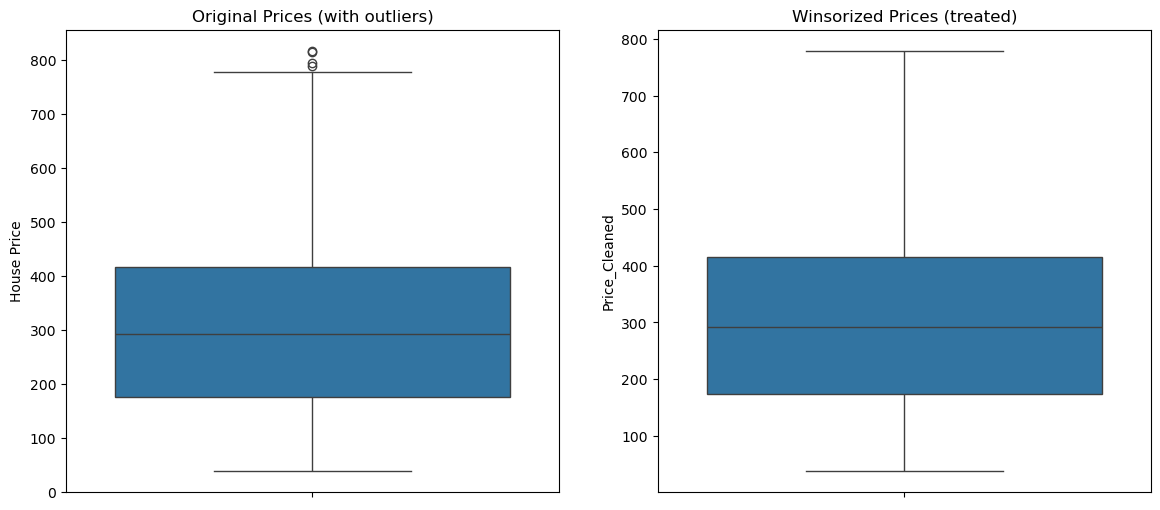

In [3]:
# Step 3: Outlier Detection and Capping (Winsorization)
Q1 = df['House Price'].quantile(0.25)
Q3 = df['House Price'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

print(f'Upper Bound for Pricing: {upper_bound:.2f} Lakhs')

# Create Cleaned Column
df['Price_Cleaned'] = np.where(df['House Price'] > upper_bound, upper_bound, df['House Price'])

# Visualization Before/After
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.boxplot(y=df['House Price'], ax=ax[0]).set_title('Original Prices (with outliers)')
sns.boxplot(y=df['Price_Cleaned'], ax=ax[1]).set_title('Winsorized Prices (treated)')
plt.show()

## 5. Model Training (60:40 Split)

### Analyst Commentary
We split our data into a **Training Set (60%)** to teach the model and a **Test Set (40%)** to grade its performance. This prevents 'overfitting'—where a model memorizes data rather than learning patterns.

### Behind the Hood: Multiple Linear Regression (MLR)
MLR finds the best-fit line through a multidimensional space. Our target is to minimize the **Residual Sum of Squares (RSS)**:

$$RSS = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

Each feature (sqft, age, etc.) gets a 'weight' or **Beta Coefficient** representing its contribution to the final price.

In [4]:
# Step 4: Preprocessing Features and Splitting Data
# Convert categorical 'property_type' to numeric format (One-Hot Encoding)
X = df.drop(['House Price', 'Price_Cleaned'], axis=1)
y = df['Price_Cleaned']

X = pd.get_dummies(X, columns=['property_type'], drop_first=True)
X = X.astype(float)

# Splitting 60% Train, 40% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Training the Model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
print('Model Training Complete')

Model Training Complete


## 6. Model Evaluation & Metrics

### Analyst Commentary
How do we know the model is good? We look at multiple metrics. No single metric tells the whole story. **R2** tells us the explained variance, while **RMSE** tells us the average ticket-size error in Lakhs.

### Behind the Hood: Metric Definitions
- **R2 (Coefficient of Determination)**: Proportion of variance in the dependent variable that is predictable from the independent variables. (Goal: closer to 1.0).
- **MAE (Mean Absolute Error)**: The average of the absolute differences between predictions and actual values. It tells us how far off our predictions are on average.
- **MSE (Mean Squared Error)**: The average of the squares of the errors. It penalizes larger errors more heavily than smaller ones.
- **RMSE (Root Mean Squared Error)**: The square root of MSE. It is in the same units as the target variable (Lakhs), making it easy to interpret.

In [5]:
# Step 5: Testing and Performance Metrics
y_pred = reg_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('--- Performance Summary ---')
print(f'R2 Score: {r2:.4f}')
print(f'MAE (Mean Absolute Error): {mae:.2f} Lakhs')
print(f'MSE (Mean Squared Error): {mse:.2f}')
print(f'RMSE (Root Mean Squared Error): {rmse:.2f} Lakhs')

--- Performance Summary ---
R2 Score: 0.8107
MAE (Mean Absolute Error): 55.30 Lakhs
MSE (Mean Squared Error): 4533.58
RMSE (Root Mean Squared Error): 67.33 Lakhs


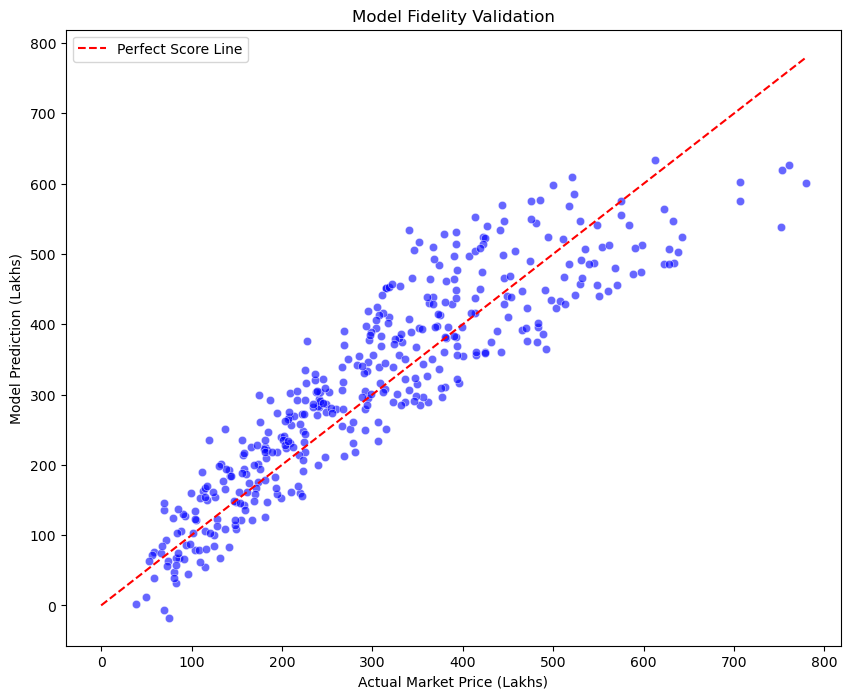

In [6]:
# Step 6: Visualizing Actual vs Predicted
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test.values, y=y_pred, alpha=0.6, color='blue')
# Identity line
max_val = max(y_test.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Perfect Score Line')
plt.xlabel('Actual Market Price (Lakhs)')
plt.ylabel('Model Prediction (Lakhs)')
plt.title('Model Fidelity Validation')
plt.legend()
plt.show()

## 7. Sample Prediction Comparisons

### Analyst Commentary
Finally, we map our predictions back to real houses. This table allows business users to spot-check individual records and build trust in the model's accuracy.

In [7]:
# Step 7: Mapping Test Data for Comparison
comparison_sample = pd.DataFrame({
    'Actual Price': y_test.values,
    'Predicted Price': np.round(y_pred, 2)
})
comparison_sample['Error'] = comparison_sample['Actual Price'] - comparison_sample['Predicted Price']
comparison_sample.head(10)

,Actual Price,Predicted Price,Error
0,225.86,334.78,-108.92
1,511.96,467.12,44.84
2,124.47,100.79,23.68
3,361.41,288.95,72.46
4,315.44,250.98,64.46
5,103.67,78.73,24.94
6,73.96,62.59,11.37
7,367.08,438.72,-71.64
8,149.68,146.79,2.89
9,83.15,31.58,51.57


## 8. Classification Performance: The Confusion Matrix

### Analyst Commentary
While this is a regression problem (predicting continuous prices), in business, we often make binary decisions: *'Is this house above or below the market median valuation?'*. To test the model's decision-making accuracy, we converted the prices into two categories: **Standard** and **Premium**.

### Behind the Hood: Confusion Matrix Math
A Confusion Matrix maps the model's 'guesses' against the 'truth':
- **True Positive (TP)**: Correctly predicted a **Premium** house.
- **True Negative (TN)**: Correctly predicted a **Standard** house.
- **False Positive (FP - Type I Error)**: Predicted 'Premium', but it was 'Standard'.
- **False Negative (FN - Type II Error)**: Predicted 'Standard', but it was 'Premium'.

#### Key Metrics Explained:
- **Precision (Quality)**: Of all the houses we predicted as 'Premium', how many actually were? High precision means we are 'careful' about calling a house premium.
- **Recall (Quantity)**: Of all the actual 'Premium' houses in the market, how many did we successfully find? High recall means we aren't 'missing' many deals.

#### Key Formulas:
$$Precision = \frac{TP}{TP + FP}$$  
$$Recall = \frac{TP}{TP + FN}$$  
$$F1 Score = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$

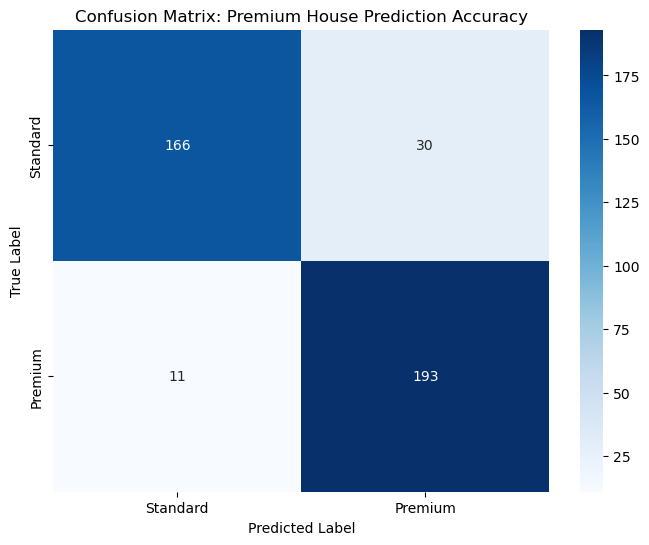

In [8]:
# Step 8: Binarizing Data and Plotting Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Binarizing at the median price
median_val = df['Price_Cleaned'].median()
y_test_bin = (y_test > median_val).astype(int)
y_pred_bin = (y_pred > median_val).astype(int)

cm = confusion_matrix(y_test_bin, y_pred_bin)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Standard', 'Premium'], 
            yticklabels=['Standard', 'Premium'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Premium House Prediction Accuracy')
plt.show()

## 9. Live Prediction: Value a New House

### Analyst Commentary
The ultimate goal of any model is **inference**—using the learned patterns to value a house that isn't in our database yet. We've created a reusable function that takes specific house features and returns a predicted price in Lakhs.

### Behind the Hood: Inference Logic
When we pass new data, the function must:
1. **Align Schema**: Ensure the property type is converted into the same 'One-Hot' binary columns (Villa, Independent House) used during training.
2. **Dot Product**: Multiply each input feature by its corresponding Beta coefficient (weight) and add the Intercept.
3. **Capping**: Since our model was trained on winsorized data, the prediction will naturally reflect the market's standard premium range.

In [13]:
def predict_house_price(total_sqft, num_bedrooms, num_bathrooms, num_balconies, 
                        num_stories, house_age, distance_to_mrt, num_convenience_stores, 
                        latitude, longitude, is_gated_community, parking_slots, 
                        property_type, floor_number, distance_to_main_road):
    # 1. Create a dictionary for the input
    input_data = {
        'total_sqft': [total_sqft],
        'num_bedrooms': [num_bedrooms],
        'num_bathrooms': [num_bathrooms],
        'num_balconies': [num_balconies],
        'num_stories': [num_stories],
        'house_age': [house_age],
        'distance_to_mrt': [distance_to_mrt],
        'num_convenience_stores': [num_convenience_stores],
        'latitude': [latitude],
        'longitude': [longitude],
        'is_gated_community': [is_gated_community],
        'parking_slots': [parking_slots],
        'floor_number': [floor_number],
        'distance_to_main_road': [distance_to_main_road]
    }
    
    # 2. Add property type columns (One-Hot Encoding handling)
    # The model expects 'property_type_Independent House' and 'property_type_Villa'
    input_data['property_type_Independent House'] = [1 if property_type == 'Independent House' else 0]
    input_data['property_type_Villa'] = [1 if property_type == 'Villa' else 0]
    
    # Convert to DataFrame
    input_df = pd.DataFrame(input_data)
    
    # Ensure column order matches X_train
    input_df = input_df[X_train.columns]
    
    # 3. Predict
    prediction = reg_model.predict(input_df)[0]
    return np.round(prediction, 2)

# --- Example Prediction Call ---
sample_price = predict_house_price(
    total_sqft=4500, num_bedrooms=3, num_bathrooms=3, num_balconies=2, 
    num_stories=2, house_age=5, distance_to_mrt=0.5, num_convenience_stores=8, 
    latitude=12.91, longitude=77.64, is_gated_community=1, parking_slots=2,
    property_type='Appartment', floor_number=0, distance_to_main_road=100
)

print(f'Estimated Price for the sample house in HSR: ₹{sample_price} Lakhs')

Estimated Price for the sample house in HSR: ₹577.16 Lakhs


## 10. The Mathematical Formula & Manual Calculation

### Analyst Commentary
In this section, we pull back the curtain on the model's coefficients. Every prediction is just a sum of features multiplied by their 'importance weights' (Coefficients). This allows the business to see exactly how much **one extra square foot** or **one extra kilometer from MRT** costs in the market.

### Behind the Hood: Coefficient Interpretation
If the coefficient for `total_sqft` is 0.08, it means for every 1 sqft increase, the price increases by ₹0.08 Lakhs (₹8,000), assuming all other factors remain constant.

In [10]:
# Step 10: Extracting Coefficients into a readable table
feature_names = X_train.columns
coefficients = reg_model.coef_
intercept = reg_model.intercept_

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight (Beta)': coefficients
}).sort_values(by='Weight (Beta)', ascending=False)

print(f'Model Intercept (Base Price): {intercept:.2f} Lakhs')
coef_df

Model Intercept (Base Price): 69725.67 Lakhs


,Feature,Weight (Beta)
15,property_type_Villa,63.597891
10,is_gated_community,35.050052
14,property_type_Independent House,11.320618
2,num_bathrooms,3.906133
11,parking_slots,2.584876
7,num_convenience_stores,1.985813
12,floor_number,0.922259
4,num_stories,0.735725
3,num_balconies,0.653243
0,total_sqft,0.115538


### Manual Math Verification
Let's take 3 actual records from our test set and calculate the price manually using the formula:

$$Price = Intercept + \sum (Feature \times Weight)$$

We will then compare our 'Manual Math' with the 'Model Prediction' to prove they are identical.

In [11]:
# Manual Prediction Demonstration
sample_indices = X_test.head(3).index
samples = X_test.head(3)

for i, (idx, row) in enumerate(samples.iterrows()):
    manual_sum = intercept + np.dot(row.values, coefficients)
    model_pred = y_pred[i]
    actual = y_test.iloc[i]
    
    print(f'--- Record {idx} ---')
    print(f'Manual Calculation: ₹{manual_sum:.2f} Lakhs')
    print(f'Model Prediction:   ₹{model_pred:.2f} Lakhs')
    print(f'Actual Market Price:₹{actual:.2f} Lakhs')
    print(f'Difference (Error): ₹{np.abs(manual_sum - model_pred):.6f}')
    print()

--- Record 521 ---
Manual Calculation: ₹334.78 Lakhs
Model Prediction:   ₹334.78 Lakhs
Actual Market Price:₹225.86 Lakhs
Difference (Error): ₹0.000000

--- Record 737 ---
Manual Calculation: ₹467.12 Lakhs
Model Prediction:   ₹467.12 Lakhs
Actual Market Price:₹511.96 Lakhs
Difference (Error): ₹0.000000

--- Record 740 ---
Manual Calculation: ₹100.79 Lakhs
Model Prediction:   ₹100.79 Lakhs
Actual Market Price:₹124.47 Lakhs
Difference (Error): ₹0.000000

